Training data size: 8000
Test data size: 10000
Validation data size: 2000


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/50
250/250 [==============================] - 32s 114ms/step - loss: 2.9326 - accuracy: 0.2404 - val_loss: 1.6915 - val_accuracy: 0.4042
Epoch 2/50
250/250 [==============================] - 31s 112ms/step - loss: 2.0940 - accuracy: 0.3414 - val_loss: 1.5058 - val_accuracy: 0.4536
Epoch 3/50
250/250 [==============================] - 31s 114ms/step - loss: 1.7987 - accuracy: 0.3880 - val_loss: 1.4496 - val_accuracy: 0.4945
Epoch 4/50
250/250 [==============================] - 31s 113ms/step - loss: 1.6660 - accuracy: 0.4210 - val_loss: 1.3476 - val_accuracy: 0.5222
Epoch 5/50
250/250 [==============================] - 31s 113ms/step - loss: 1.5381 - accuracy: 0.4620 - val_loss: 1.3147 - val_accuracy: 0.5368
Epoch 6/50
250/250 [==============================] - 31s 114ms/step - loss: 1.4373 - accuracy: 0.4965 - val_loss: 1.3062 - val_accuracy: 0.5348
Epoch 7/50
250/250 [==============================] - 31s 113ms/step - loss: 1.3701 - accuracy: 0.5197 - val_loss: 1.2461 - val_ac

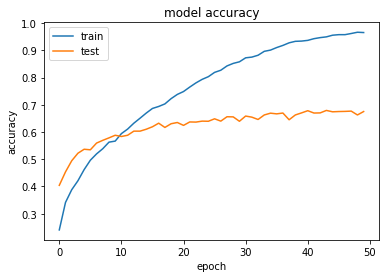

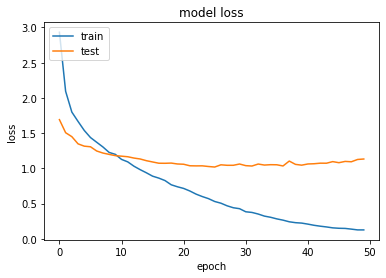

In [6]:
import os
import time

import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

(train_images, train_labels), (test_images, test_labels) = keras.datasets.cifar10.load_data()

CLASS_NAMES = ('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

validation_images, validation_labels = train_images[:2000], train_labels[:2000]
train_images, train_labels = train_images[2000:10000], train_labels[2000:10000]

train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
test_ds = tf.data.Dataset.from_tensor_slices((test_images, test_labels))
validation_ds = tf.data.Dataset.from_tensor_slices((validation_images, validation_labels))

def process_images(image, label):
    # Normalize images to have a mean of 0 and standard deviation of 1
    image = tf.image.per_image_standardization(image)
    # Resize images from 32x32 to 277x277
    image = tf.image.resize(image, (227,227))
    return image, label

train_ds_size = tf.data.experimental.cardinality(train_ds).numpy()
test_ds_size = tf.data.experimental.cardinality(test_ds).numpy()
validation_ds_size = tf.data.experimental.cardinality(validation_ds).numpy()
print("Training data size:", train_ds_size)
print("Test data size:", test_ds_size)
print("Validation data size:", validation_ds_size)

train_ds = (train_ds
                  .map(process_images)
                  .shuffle(buffer_size=train_ds_size)
                  .batch(batch_size=32, drop_remainder=True))
test_ds = (test_ds
                  .map(process_images)
                  .shuffle(buffer_size=train_ds_size)
                  .batch(batch_size=32, drop_remainder=True))
validation_ds = (validation_ds
                  .map(process_images)
                  .shuffle(buffer_size=train_ds_size)
                  .batch(batch_size=32, drop_remainder=True))

model = keras.models.Sequential([
    keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(227,227,3)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation='softmax')
])

root_logdir = os.path.join(os.curdir, "logs\\fit\\")
def get_run_logdir():
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)
run_logdir = get_run_logdir()
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.optimizers.SGD(lr=0.001), metrics=['accuracy'])

history = model.fit(train_ds,
          epochs=50,
          validation_data=validation_ds,
          validation_freq=1,
          callbacks=[tensorboard_cb])

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.figure()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.show()
